<a href="https://colab.research.google.com/github/rameeyboy96/Master-thesis/blob/main/Byesian_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import datetime
import json



import pandas as pd
import numpy as np
import math
from numpy import sqrt
import missingno as msno


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.decomposition import PCA
from scipy.stats import boxcox

from sklearn.ensemble import RandomForestRegressor
import xgboost 
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

import pandas as pd # for data manipulation 
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs

# for creating Bayesian Belief Networks (BBN)


from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


In [ ]:
!pip install pybbn
!pip install snoop

  Created wheel for pybbn: filename=pybbn-3.2.1-cp37-none-any.whl size=39725 sha256=c6416d83dc37895c2b8f10bac4d7a456041a03496531f3b3845e2eb191326018
  Stored in directory: /root/.cache/pip/wheels/ff/c3/66/eb77d2de44377277f3e2db6f0e498896c0d6cd7225cffffd18
Successfully built pybbn
  Created wheel for snoop: filename=snoop-0.3.0-cp37-none-any.whl size=27305 sha256=882aa50fc764ecc89f207164987b089b3b7eabc7fe09452cb472fcdf83d8d003
  Stored in directory: /root/.cache/pip/wheels/ac/20/35/35a8bbaf50a7fe2dc64161d3a7a60363e65fe2dca44c3c20cc
  Created wheel for cheap-repr: filename=cheap_repr-0.4.5-cp37-none-any.whl size=7121 sha256=b2126fe2bf47b02c1fc0bc4331109d343806b53efbfef781d20031ce1f484729
  Stored in directory: /root/.cache/pip/wheels/67/31/35/c7f1495f969b6e9a71a2bd6e777174d71eced3257c1d3e7018
Successfully built snoop cheap-repr


In [ ]:
#functions for cleaning and reindexing the value
INPUT_DATA_PATH= '/content/drive/MyDrive/MVA/'

def read_ecoli_lab(label, log_scale=False):
    filename= label  + '.csv'
    fpath=INPUT_DATA_PATH + filename
    dataset=pd.read_csv(fpath, parse_dates=['timestamp'])
    dataset.index=pd.DatetimeIndex(dataset['timestamp'].dt.date)
    dataset=dataset.drop(labels='timestamp', axis=1)
    dataset=dataset[~dataset.index.duplicated(keep='last')]
    dataset=dataset.reindex(pd.date_range(dataset.index.min(), dataset.index.max(), freq='D'))
    new_label= label.split('_')[0] + '_LAB_' + label.split('_')[1]
    
    dataset=dataset.rename(columns={label:new_label})
    if log_scale:
        dataset[new_label]=np.log10(dataset[new_label]+1)
    

        
    return dataset

def read_water_temp(label):

    #
    # Water Temp
    #
    
    filename = label  + '.csv'
    fpath=os.path.join(INPUT_DATA_PATH, filename)
    
    df = pd.read_csv(
        fpath,
        parse_dates=['timestamp']
    )
    
    df.index = pd.DatetimeIndex(df['timestamp'].dt.date)
    df = df.drop(labels='timestamp', axis=1)
    df = df[~df.index.duplicated(keep='last')] # Keep last measurement every day.
    df = df.reindex(pd.date_range(df.index.min(), df.index.max(), freq='D'))
    #df[label] = ~df[label].isnull()

    return df

def read_turbidity(label, log_scale=False):

    #
    # Turbidity
    #
    
    filename = label + '.csv'
    fpath=os.path.join(INPUT_DATA_PATH, filename)
    
    df = pd.read_csv(
        fpath,
        parse_dates=['timestamp']
    )
    
    df.index = pd.DatetimeIndex(df['timestamp'].dt.date)
    df = df.drop(labels='timestamp', axis=1)
    df = df[~df.index.duplicated(keep='last')]
    df = df.reindex(pd.date_range(df.index.min(), df.index.max(), freq='D'))
    #df[label] = ~df[label].isnull()

    if log_scale:
        df[label] = np.log10(df[label]+1)

    return df


def read_coliforms(label, log_scale=False):
    
    #
    # Coliforms
    #
    filename = label  + '.csv'
    fpath=os.path.join(INPUT_DATA_PATH, filename)
    
    df = pd.read_csv(
        fpath,
        parse_dates=['timestamp']
    )
    
    df.index = pd.DatetimeIndex(df['timestamp'].dt.date)
    df = df.drop(labels='timestamp', axis=1)
    df = df[~df.index.duplicated(keep='last')]
    df = df.reindex(pd.date_range(df.index.min(), df.index.max(), freq='D'))
    #df[label] = ~df[label].isnull()

    if log_scale:
        df[label] = np.log10(df[label]+1)

    return df


def read_color(label, log_scale=False):
    
    #
    # Color
    #
    filename = label  + '.csv'
    fpath=os.path.join(INPUT_DATA_PATH, filename)
    
    df = pd.read_csv(
        fpath,
        parse_dates=['timestamp']
    )
    
    df.index = pd.DatetimeIndex(df['timestamp'].dt.date)
    df = df.drop(labels='timestamp', axis=1)
    df = df[~df.index.duplicated(keep='last')]
    df = df.reindex(pd.date_range(df.index.min(), df.index.max(), freq='D'))

    if log_scale:
        df[label] = np.log10(df[label]+1)

    return df

def read_conductivity(label, log_scale=False):
    
    #
    # conductivity
    #
    filename = label + '.csv'
    fpath=os.path.join(INPUT_DATA_PATH, filename)
    
    df = pd.read_csv(
        fpath,
        parse_dates=['timestamp']
    )
    
    df.index = pd.DatetimeIndex(df['timestamp'].dt.date)
    df = df.drop(labels='timestamp', axis=1)
    df = df[~df.index.duplicated(keep='last')]
    df = df.reindex(pd.date_range(df.index.min(), df.index.max(), freq='D'))

    if log_scale:
        df[label] = np.log10(df[label]+1)
    
    return df
def read_precipitation(label, is_daily_precip=True):

	#
	# Precipitation
	#
	
	filename = label + '.csv'
	fpath=os.path.join(INPUT_DATA_PATH, filename)

	df = pd.read_csv(
		fpath,
		parse_dates=['timestamp']
	)
	
	if is_daily_precip:
		df.index = pd.DatetimeIndex(df['timestamp'].dt.date)
		df = df.drop(['timestamp', 'qual_' + label], axis=1)
		df = df.reindex(pd.date_range(df.index.min(), df.index.max(), freq='D'))
		df[label] = df[label].shift(-1)
		
	else:
		df.index = pd.DatetimeIndex(df['timestamp'])
		df = df.drop(['timestamp', 'qual_' + label], axis=1)        
		df = df.groupby(pd.Grouper(freq = '24H', offset='6H', closed='right')).sum()
		df.index = pd.DatetimeIndex(df.index.date)
		df = df.reindex(pd.date_range(df.index.min(), df.index.max(), freq='D'))
	
	return df

def read_ecoli_colifast(label):

#
# E.coli Colifast
#

    colifast_map = {
    '<50': 1,
    '50': 2,
    '100': 3,
    '200': 4,
    '400': 5,
    '>400': 6
    }
    
    filename = label  + '.csv'
    fpath=os.path.join(INPUT_DATA_PATH, filename)

    df = pd.read_csv(
    fpath,
    parse_dates=['timestamp']
    )
    
    df['ds'] = df['timestamp'].dt.date
    df = df.groupby('ds').nth([0, -1]) # Keep first and last measurement every day.
    df = df.drop(labels='timestamp', axis=1)
    df[label] = df[label].map(colifast_map).astype(float)
    df = df.rename(columns={label: 'ecoli_' + label})    
    
    df_first=df.groupby('ds').nth(0)
    df_first=df_first.reindex(pd.date_range(df_first.index.min(), df_first.index.max(), freq='D'))
    
    df_second=df.groupby('ds').nth(-1)
    df_first=df_first.reindex(pd.date_range(df_first.index.min(), df_first.index.max(), freq='D'))
    
    df=df_first.join(df_second, how='outer', lsuffix='_1st', rsuffix='_2nd')
            
    return df




def read_flow_rate(label, log_scale=False):

    #
    # Flow Rate
    #
    
    filename = label + '.csv'
    fpath=os.path.join(INPUT_DATA_PATH, filename)
    df = pd.read_csv(
        fpath,
        parse_dates=['timestamp']
    )
    
    df.index = pd.DatetimeIndex(df['timestamp'].dt.date)
    df = df.drop(labels='timestamp', axis=1)
    df = df.reindex(pd.date_range(df.index.min(), df.index.max(), freq='D'))
    
    if log_scale:
        df[label]=np.log10(df[label]+2)
        
    return df







## Getting the values from the functions and preparing a dataset called df


In [ ]:


df=read_ecoli_lab('ecoli_LAE', True)
#df=df.join(read_ecoli_lab('ecoli_GA', True))
#df=df.join(read_ecoli_lab('ecoli_SU', True))
#df=df.join(read_ecoli_lab('ecoli_SN', True))

df=df.join(read_coliforms('coliforms_LAE', True))
#df=df.join(read_coliforms('coliforms_GA', True))

#df = df.join(read_ecoli_colifast('colifast_LAE'))
#df=df.join(read_ecoli_colifast('colifast_GA'))


df=df.join(read_water_temp('waterTemp_LAE'))
df=df.join(read_color('color_LAE', True))
#df=df.join(read_entercocci('enterococciMF_LAE', True))
df = df.join(read_conductivity('cond_LAE', False))

df=df.join(read_turbidity('turb_LAE', True))
#df=df.join(read_turbidity('turb_GA'))


df=df.join(read_precipitation('precipitation_GBG', False))
#df = df.join(read_precipitation('precipitation_VB', True))
#df = df.join(read_precipitation('precipitation_KR', True))


#df = df.join(read_flow_rate('flowrate_LE', True))
#df = df.join(read_flow_rate('flowrate_GG', True))


df

,ecoli_LAB_LAE,coliforms_LAE,waterTemp_LAE,color_LAE,cond_LAE,turb_LAE,precipitation_GBG
2012-01-02,2.344392,2.813581,4.8,NaN,9.0,0.908485,0.5
2012-01-03,NaN,NaN,NaN,NaN,NaN,NaN,21.3
2012-01-04,2.478566,2.892651,4.9,1.322219,9.2,0.977724,7.0
2012-01-05,2.492760,3.176381,4.7,NaN,9.4,1.507856,0.2
2012-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...
2019-12-26,2.178977,2.492760,4.6,NaN,8.6,0.799341,NaN
2019-12-27,2.206826,2.592177,4.2,NaN,8.6,0.806180,NaN
2019-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# New section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#information about the dataset, about the datatype.

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2920 entries, 2012-01-02 to 2019-12-30
Freq: D
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ecoli_LAB_LAE      1290 non-null   float64
 1   coliforms_LAE      1331 non-null   float64
 2   waterTemp_LAE      1400 non-null   float64
 3   color_LAE          317 non-null    float64
 4   cond_LAE           1252 non-null   float64
 5   turb_LAE           1246 non-null   float64
 6   precipitation_GBG  2860 non-null   float64
dtypes: float64(7)
memory usage: 262.5 KB


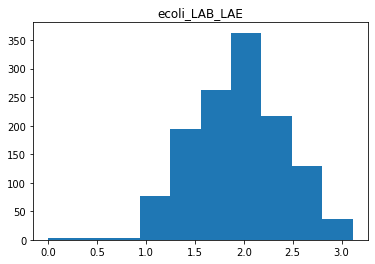

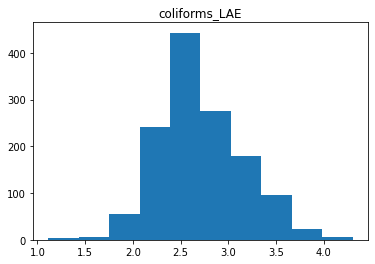

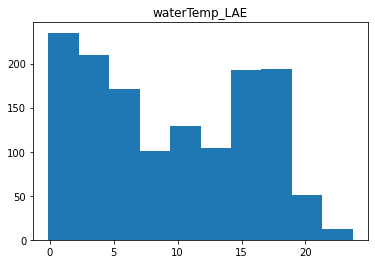

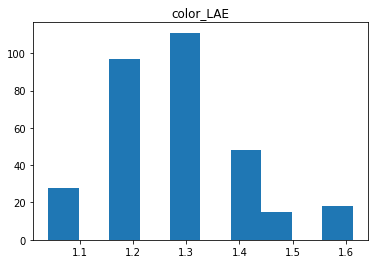

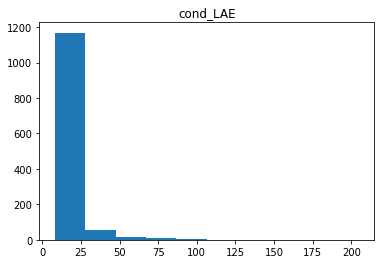

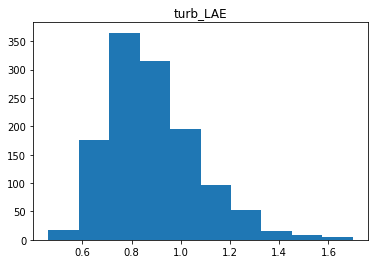

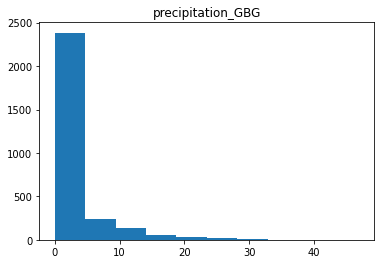

In [ ]:
#visualization of columns:

def visualization_col(df):
    for label in df.columns:
        plt.hist(df[label])
        plt.title(label)
        plt.show()

visualization_col(df)

,ecoli_LAB_LAE,coliforms_LAE,waterTemp_LAE,color_LAE,cond_LAE,turb_LAE,precipitation_GBG
ecoli_LAB_LAE,1.000000,0.708266,-0.476657,0.506150,0.008095,0.554674,0.050828
coliforms_LAE,0.708266,1.000000,-0.043374,0.322026,0.036788,0.512228,0.099314
waterTemp_LAE,-0.476657,-0.043374,1.000000,-0.398411,0.001990,-0.263602,0.014972
color_LAE,0.506150,0.322026,-0.398411,1.000000,0.068541,0.425089,0.013744
cond_LAE,0.008095,0.036788,0.001990,0.068541,1.000000,-0.033354,0.006010
turb_LAE,0.554674,0.512228,-0.263602,0.425089,-0.033354,1.000000,0.028426
precipitation_GBG,0.050828,0.099314,0.014972,0.013744,0.006010,0.028426,1.000000


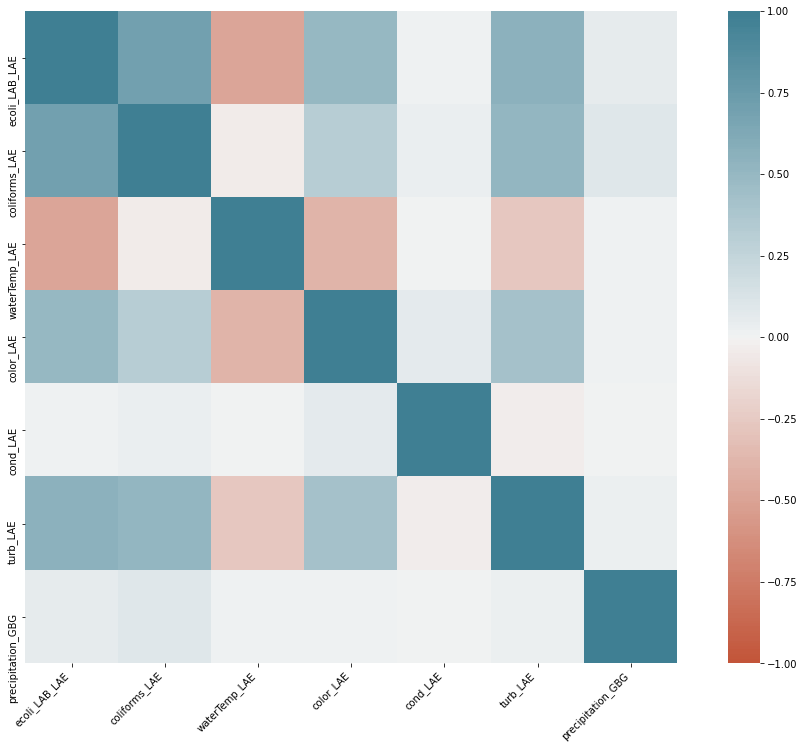

In [ ]:
 
    
    
plt.figure(figsize=(18,12), facecolor='w')
corr = df.corr(method='pearson')
display(corr)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
# lets create a Bayesian Network

df=df[pd.isnull(df['ecoli_LAB_LAE'])==False]



In [ ]:
df.describe()

,ecoli_LAB_LAE,coliforms_LAE,waterTemp_LAE,color_LAE,cond_LAE,turb_LAE,precipitation_GBG
count,1290.000000,1331.000000,1400.000000,317.000000,1252.000000,1246.000000,2860.000000
mean,1.928949,2.712754,9.451164,1.297151,11.936733,0.887359,2.333776
std,0.475924,0.443557,6.326784,0.129253,13.036260,0.187859,4.816725
min,0.000000,1.113943,-0.100000,1.041393,8.000000,0.462398,0.000000
25%,1.623249,2.416641,3.500000,1.204120,8.400000,0.755875,0.000000
50%,1.939519,2.644439,8.900000,1.322219,8.600000,0.863323,0.000000
75%,2.232996,2.982723,15.700000,1.414973,9.000000,0.982271,2.300000
max,3.114277,4.301052,23.700000,1.612784,205.000000,1.698970,46.900000


In [132]:
df['wt_band']= df['waterTemp_LAE'].apply(lambda x: 'low' if x<=3.4 else
                                                       'middle' if 3.4<x<=8.5 else 'high' if 8.5<x<=15.5 else 'extreme')
df['turb_band']=df['turb_LAE'].apply(lambda x: 'low' if x<=0.75 else 'middle' if 0.75<x<=0.86 else 'high' if 0.86<x<=0.98 else 'extreme')

df['ecoli_band']= df['ecoli_LAB_LAE'].apply(lambda x: 'low' if x<=1.62 else 'middle' if 1.62<x<=1.93 else 'high' if 1.93<x<=2.23 else 'extreme')

df['coli_band']= df['coliforms_LAE'].apply(lambda x: 'low' if x<=2.41 else 'middle' if 2.4<x<=2.64 else 'high' if 2.64<x<=2.98 else 'extreme')

df['color_band']= df['color_LAE'].apply(lambda x: 'low' if x<=1.20 else 'middle' if 1.20<x<=1.32 else 'high' if 1.32<x<=1.41 else 'extreme')

df['cond_band']= df['cond_LAE'].apply(lambda x: 'low' if x<=8 else 'middle' if 8<x<=8.4 else 'high' if 8.4<x<=9 else 'extreme')


In [133]:
df

,ecoli_LAB_LAE,coliforms_LAE,waterTemp_LAE,color_LAE,cond_LAE,turb_LAE,precipitation_GBG,wt_band,turb_band,ecoli_band,coli_band,color_band,cond,cond_band
2012-01-02,2.344392,2.813581,4.8,NaN,9.0,0.908485,0.5,middle,high,extreme,high,extreme,high,high
2012-01-03,NaN,NaN,NaN,NaN,NaN,NaN,21.3,extreme,extreme,extreme,extreme,extreme,extreme,extreme
2012-01-04,2.478566,2.892651,4.9,1.322219,9.2,0.977724,7.0,middle,high,extreme,high,high,extreme,extreme
2012-01-05,2.492760,3.176381,4.7,NaN,9.4,1.507856,0.2,middle,extreme,extreme,extreme,extreme,extreme,extreme
2012-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0.0,extreme,extreme,extreme,extreme,extreme,extreme,extreme
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-26,2.178977,2.492760,4.6,NaN,8.6,0.799341,NaN,middle,middle,high,middle,extreme,high,high
2019-12-27,2.206826,2.592177,4.2,NaN,8.6,0.806180,NaN,middle,middle,high,middle,extreme,high,high
2019-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,extreme,extreme,extreme,extreme,extreme,extreme,extreme
2019-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,extreme,extreme,extreme,extreme,extreme,extreme,extreme


In [134]:
#setting up thr Bayesian Network -# This function helps to calculate probabily distribution, 
#which goes into BBN (note, can handle upto 2 parents)
import snoop



def probs(df, child , parent1=None, parent2=None, parent3=None):
    prob=[]
    if parent1==None:
        prob=df[child].value_counts(normalize=True, sort=False).sort_index().tolist()
    elif parent1!=None:

        #check if child node has 1 or 2 parents 
        if parent2== None:
            bands=df[parent1].value_counts(sort=False).sort_index().index.tolist()
            
            #calculate joint proabilities
            for val in bands:
                temp= df[df[parent1]==val][child].value_counts(normalize=True).sort_index().tolist()
                
                # calculate the joint probabilities - 
                prob=prob + temp

        elif parent2!= None:
            if parent3==None:

              bands1=df[parent1].value_counts(sort=False).sort_index().index.tolist()
              bands2=df[parent2].value_counts(sort=False).sort_index().index.tolist()

              for val1 in bands1:
                  for val2 in bands2:
                      temp=df[(df[parent1]==val1) & (df[parent2]==val2)][child].value_counts(normalize=True, sort=False).sort_index().tolist()
                      prob= prob + temp

                
            else:
      
            
            # work out the bands present in the parent variable
            
              bands1=df[parent1].value_counts(sort=False).sort_index().index.tolist()
              bands2=df[parent2].value_counts(sort=False).sort_index().index.tolist()
              bands3=df[parent3].value_counts(sort=False).sort_index().index.tolist()

            
            #calculate probabilities
            
              for val1 in bands1:
                  for val2 in bands2:
                      for val3 in bands3:
                          temp=df[(df[parent1]==val1) & (df[parent2]==val2) & (df[parent3]==val3)][child].value_counts(normalize=True,
                                                                                                   sort=False).sort_index().tolist()
                          prob=prob + temp
    else:
        print('Error')
    
    return prob
                

In [136]:
# Create nodes by using our earlier function to automatically calculate probabilities

#pres= probs(df, child='precipitation_band')
wt= BbnNode(Variable(0,'WT', ['low','middle', 'high','extreme']), probs(df, child='wt_band'))
turb=BbnNode(Variable(1,'turb', ['low','middle','high','extreme']), probs(df, child='turb_band'))
color=BbnNode(Variable(2, 'color', ['low','middle','high','extreme']), probs(df, child='color_band'))
cond=BbnNode(Variable(3, 'cond', ['low','middle','high','extreme']), probs(df, child='cond_band'))
coli=BbnNode(Variable(4,'coli',['low','middle','high','extreme']), probs(df, child='coli_band', parent1='wt_band', parent2='turb_band', parent3='cond_band'))
ecoli=BbnNode(Variable(5,'ecoli', ['low','middle','high','extreme']), probs(df, child='ecoli_band', parent1='coli_band', parent2='color_band'))



#flow= probs(df, child='flowrate_band')
#ecoli= probs(df, child='ecoli_cat',parent1='precipitation_band', parent2='flowrate_band')
#display(ecoli)

In [137]:
bbn=Bbn() \
.add_node(wt) \
.add_node(turb) \
.add_node(color) \
.add_node(cond) \
.add_node(coli) \
.add_node(ecoli) \
.add_edge(Edge(wt, coli, EdgeType.DIRECTED)) \
.add_edge(Edge(turb,coli, EdgeType.DIRECTED)) \
.add_edge(Edge(cond,coli, EdgeType.DIRECTED)) \
.add_edge(Edge(coli,ecoli, EdgeType.DIRECTED)) \
.add_edge(Edge(color,ecoli, EdgeType.DIRECTED)) \




In [138]:
join_tree= InferenceController.apply(bbn)

IndexError: ignored

In [ ]:
# Define a function for printing marginal probabilities
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')
        
# Use the above function to print marginal probabilities
print_probs()

NameError: ignored

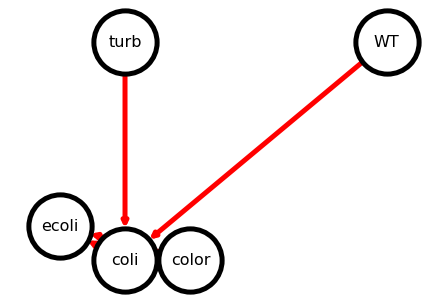

In [ ]:
# Set node positions
pos = {0: (2, 5), 1: (-2, 5), 2: (-1, 0.5), 3:(-2,0.5), 4:(-3,1.2)}

# Set options for graph looks
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "red",
    "linewidths": 5,
    "width": 5,}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()

In [ ]:
# To add evidence of events that happened so probability distribution can be recalculate
ev=EvidenceBuilder()
ev2= EvidenceBuilder()
ev3= EvidenceBuilder()


def evidence(ev,nod, cat, val):
  ev=EvidenceBuilder() \
  .with_node(join_tree.get_bbn_node_by_name(nod)) \
  .with_evidence(cat, val) \
  .build()
  join_tree.set_observation(ev)


In [ ]:
#Let’s say it is 9 am right now, and we have measured 
#the precipitation outside. It says 12mm, which obviously belongs to the “>10” band.
#Hence, let’s pass this evidence into the BBN and see what happens. 
#Note, I have created another small function to help us with that.

#use the above function to add evidence

evidence(ev,'WT','extreme', 1.0)

print_probs()


Node: 3|coli|low,middle,high,extreme
Values:
3=low|0.55566
3=middle|0.23528
3=high|0.09309
3=extreme|0.11597
----------------
Node: 4|ecoli|low,middle,high,extreme
Values:
4=low|0.67715
4=middle|0.13615
4=high|0.08883
4=extreme|0.09787
----------------
Node: 1|turb|low,middle,high,extreme
Values:
1=low|0.63994
1=middle|0.12397
1=high|0.11843
1=extreme|0.11766
----------------
Node: 0|WT|low,middle,high,extreme
Values:
0=low|0.62533
0=middle|0.11728
0=high|0.13064
0=extreme|0.12675
----------------


In [ ]:
evidence(ev2,'turb', 'low', 1.0)
evidence(ev3, 'coli', 'middle', 1.0)

print_probs()

Node: 3|coli|low,middle,high,extreme
Values:
3=low|0.00000
3=middle|1.00000
3=high|0.00000
3=extreme|0.00000
----------------
Node: 4|ecoli|low,middle,high,extreme
Values:
4=low|0.33333
4=middle|0.16667
4=high|0.25000
4=extreme|0.25000
----------------
Node: 1|turb|low,middle,high,extreme
Values:
1=low|0.33075
1=middle|0.26009
1=high|0.21301
1=extreme|0.19615
----------------
Node: 0|WT|low,middle,high,extreme
Values:
0=low|0.46339
0=middle|0.11331
0=high|0.23204
0=extreme|0.19126
----------------
